# Reinforcement Learning

# 3. Online evaluation

This notebook presents the online evaluation of a policy by **Monte-Carlo learning** and **TD learning**.


In [982]:
import sys
from pathlib import Path

lib_path = str(Path.cwd().parent)

if lib_path not in sys.path:
    sys.path.append(lib_path)
print(sys.path)

['C:\\Python312\\python312.zip', 'C:\\Python312\\DLLs', 'C:\\Python312\\Lib', 'C:\\Python312', 'd:\\Code\\Reinforcement Learning\\venv', '', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32\\lib', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\Pythonwin', 'd:\\Code\\Reinforcement Learning']


In [983]:
import numpy as np
import matplotlib.pyplot as plt

In [984]:
from lib.model import Maze, Walk, TicTacToe, Nim, ConnectFour
from lib.agent import Agent, OnlineEvaluation
from lib.dynamic import PolicyEvaluation, ValueIteration

## To do:


- Complete the class `MCLearning` and test it on the random walk.
- Compare with the exact solution obtained by Dynamic Programming.<br> You might plot the [Spearman's correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between both value functions with respect to the training time.
- Do the same with `TDLearning`.


## Monte-Carlo learning:


In [985]:
class MCLearning(OnlineEvaluation):
    """Online evaluation by Monte-Carlo."""

    def update_values(self, state=None, horizon=100):
        """Update the values from one episode."""
        stop, states, rewards = self.get_episode(state=state, horizon=horizon)
        # remove last state
        states.pop()
        gain = 0
        # backward update
        for state, reward in zip(reversed(states), reversed(rewards)):
            self.add_state(state)
            code = self.model.encode(state)
            self.count[code] += 1
            # to be modified
            # begin
            gain = reward + self.gamma * gain
            # end
            diff = gain - self.value[code]
            count = self.count[code]
            self.value[code] += diff / count

## TD learning:


In [986]:
class TDLearning(OnlineEvaluation):
    """Online evaluation by TD learning."""

    def update_values(self, state=None, horizon=100):
        """Update values online from one episode."""
        self.model.reset(state)
        for _ in range(horizon):
            state = self.model.state
            # to be completed
            if self.model.is_terminal(state):
                break
            action = self.get_action(state)
            reward, stop = self.model.step(action)
            next_state = self.model.state
            self.add_state(state)
            self.add_state(next_state)
            code = self.model.encode(state)
            next_code = self.model.encode(next_state)
            self.count[code] += 1
            diff = reward + self.gamma * self.value[next_code] - self.value[code]
            self.value[code] += diff / self.count[code]

## Walk:


In [987]:
walk = Walk()

### Test Monte-Carlo learning on Walk:


In [988]:
algo = MCLearning(walk, policy="random", gamma=0.9)

In [989]:
n_episodes = 100
mc_values_array = []

for t in range(n_episodes):
    algo.update_values()
    mc_values_array.append(algo.get_values())

In [990]:
mc_values = algo.get_values()
policy = algo.get_policy()

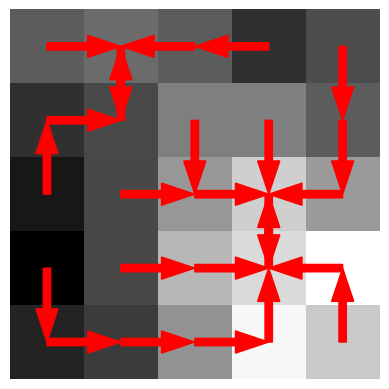

In [991]:
walk.display_policy(policy)
walk.display_values(mc_values)

### Compare with value function obtained with Dynamic Programming:


In [992]:
walk = Walk()

algo = ValueIteration(walk, gamma=0.9)
opt_policy = algo.get_optimal_policy()
opt_values = algo.values

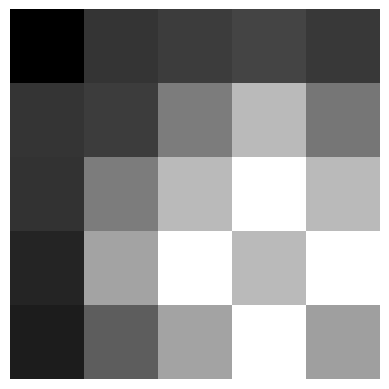

In [993]:
walk.display_values(opt_values)

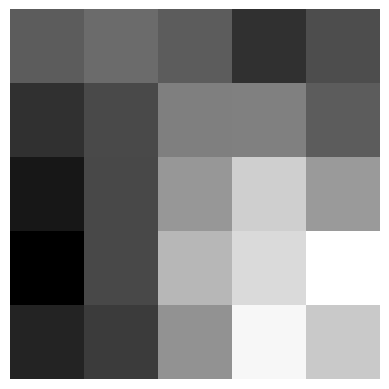

In [994]:
walk.display_values(mc_values)

### Test TD learning on Walk:


In [995]:
walk = Walk()

In [996]:
algo = TDLearning(walk, policy="random", gamma=0.9)

In [997]:
n_episodes = 100
td_values_array = []

for t in range(n_episodes):
    algo.update_values()
    td_values_array.append(algo.get_values())

In [998]:
td_values = algo.get_values()
policy = algo.get_policy()

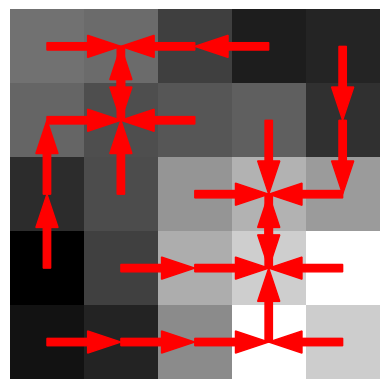

In [999]:
walk.display_policy(policy)
walk.display_values(td_values)

### Compare with value function obtained with Dynamic Programming:


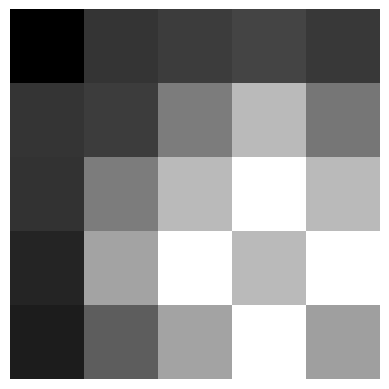

In [1000]:
walk.display_values(opt_values)

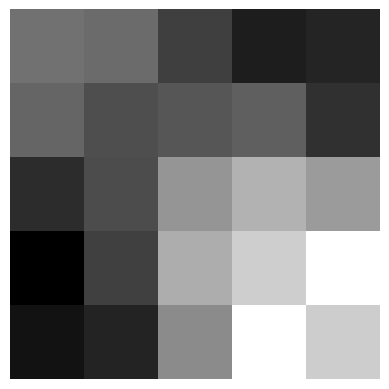

In [1001]:
walk.display_values(td_values)

### Spearman correlation for the two methods:


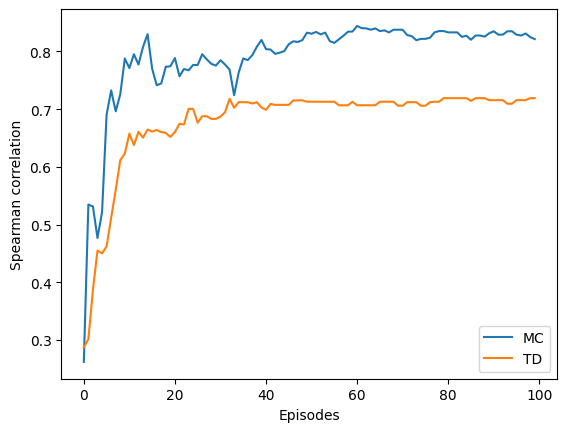

In [1002]:
from scipy.stats import spearmanr

spearman_td = [spearmanr(opt_values, values).statistic for values in td_values_array]
spearman_mc = [spearmanr(opt_values, values).statistic for values in mc_values_array]

plt.figure()
plt.plot(spearman_mc, label="MC")
plt.plot(spearman_td, label="TD")
plt.xlabel("Episodes")
plt.ylabel("Spearman correlation")
plt.legend()
plt.show()

## To do:

Test the other environments:

- The maze: can you find the exit after policy improvement?<br> You might adapt the number of episodes used for training.
- The games (Tic-Tac-Toe, Nim, Connect Four): can you beat a random player after policy improvement? a player with the one-step policy?<br> Comment the results.


## Maze:


In [1003]:
maze_map = np.load("../lib/maze.npy")

In [1004]:
init_state = (1, 0)
exit_state = (1, 20)
Maze.set_parameters(maze_map, init_state, [exit_state])

In [1005]:
maze = Maze()

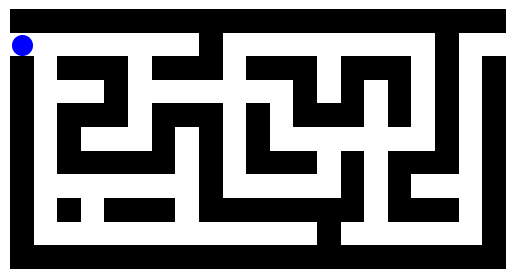

In [1006]:
maze.display()

### Test Monte-Carlo learning on Maze:


In [1007]:
algo = MCLearning(maze, policy="random", gamma=0.9)

In [1008]:
n_episodes = 2000
for t in range(n_episodes):
    algo.update_values(state="random")

In [1009]:
values = algo.get_values()
policy = algo.get_policy()

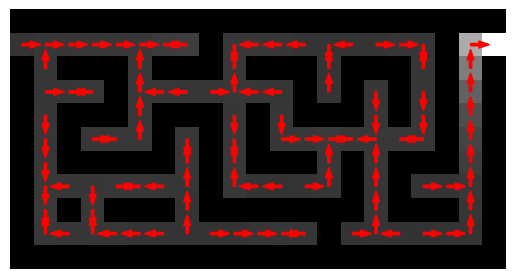

In [1010]:
maze.display_policy(policy)
maze.display_values(values)

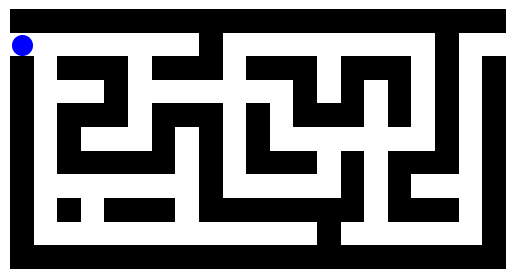

In [1011]:
agent = Agent(maze, policy)
stop, states, rewards = agent.get_episode()
animation = maze.display(states)

In [1012]:
animation

### Test TD learning on Maze:


In [1013]:
maze = Maze()

In [1014]:
algo = TDLearning(maze, policy="random", gamma=0.9)

In [1015]:
n_episodes = 2000
for t in range(n_episodes):
    algo.update_values(state="random")

In [1016]:
values = algo.get_values()
policy = algo.get_policy()

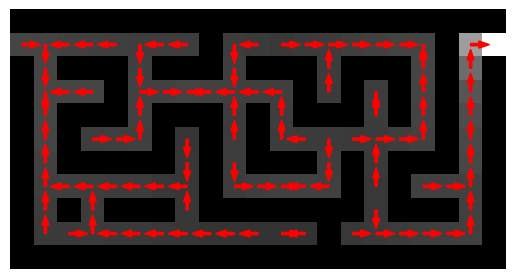

In [1017]:
maze.display_policy(policy)
maze.display_values(values)

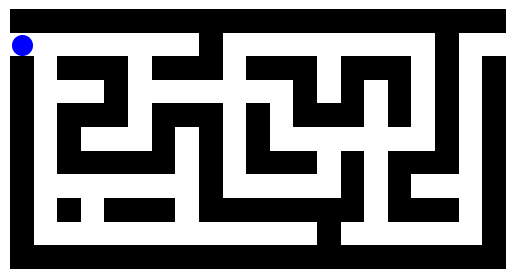

In [1018]:
agent = Agent(maze, policy)
stop, states, rewards = agent.get_episode(horizon=500)
animation = maze.display(states)

In [1019]:
animation

## Games:


### Tic-Tac-Toe:


### Random player:


In [1020]:
game = TicTacToe()

### Monte-Carlo learning:


In [1021]:
algo = MCLearning(game, policy="random", gamma=0.9)
n_episodes = 300
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([ 4,  1, 95]))

### TD learning:


In [1022]:
algo = TDLearning(game, policy="random", gamma=0.9)
n_episodes = 300
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([18,  3, 79]))

### Player with the one-step policy:


In [1023]:
game = TicTacToe(adversary_policy="one_step")

### Monte-Carlo learning:


In [1024]:
algo = MCLearning(game, policy="random", gamma=0.9)
n_episodes = 300
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([51, 26, 23]))

### TD learning:


In [1025]:
algo = TDLearning(game, policy="random", gamma=0.9)
n_episodes = 300
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([54, 32, 14]))

### Nim:


In [1026]:
game = Nim()

### Monte-Carlo learning:


In [1027]:
algo = MCLearning(game, policy="random", gamma=0.9)
n_episodes = 300
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([11, 89]))

### TD learning:


In [1028]:
algo = TDLearning(game, policy="random", gamma=0.9)
n_episodes = 300
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([15, 85]))

### Player with the one-step policy:


In [1029]:
game = Nim(adversary_policy="one_step")

### Monte-Carlo learning:


In [1030]:
algo = MCLearning(game, policy="random", gamma=0.9)
n_episodes = 300
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([ 8, 92]))

### TD learning:


In [1031]:
algo = TDLearning(game, policy="random", gamma=0.9)
n_episodes = 300
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([18, 82]))

### Connect Four:


In [1032]:
game = ConnectFour()

### Monte-Carlo learning:


In [1033]:
algo = MCLearning(game, policy="random", gamma=0.9)
n_episodes = 100
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([15, 85]))

### TD learning:


In [1034]:
algo = TDLearning(game, policy="random", gamma=0.9)
n_episodes = 100
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([19, 81]))

### Player with the one-step policy:


In [1035]:
game = ConnectFour(adversary_policy="one_step")

### Monte-Carlo learning:


In [1036]:
algo = MCLearning(game, policy="random", gamma=0.9)
n_episodes = 100
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([89, 11]))

### TD learning:


In [1037]:
algo = TDLearning(game, policy="random", gamma=0.9)
n_episodes = 100
for t in range(n_episodes):
    algo.update_values()
policy = algo.get_policy()
agent = Agent(game, policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([81, 19]))